In [1]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR.

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Train model
Using the author's parameters, but vary in the number of filters, number of layers, and increase the filter length to 30+ in order to try and capture long-range interactions

In [171]:
# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=30, filter_len=50, dropout1=0,
#                     dropout2=0,dropout3=0.2)

In [ ]:
# e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test['rl'], e_test['pred'])
# print 'r-squared = ', r
# print 'r-squared of original model = 0.9338...'

In [ ]:
#model.save('./saved_models/long_range_model_50bp.hdf5')

### How important is the size of the model? 
Does reducing its size only lose a small amount of r-squared, like with the 8-bp window CNN? That might seem to indicate that the total information content available is limited, but maybe that's not the correct interpretation...?

In [5]:
# np.random.seed(1337)
# small_model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=5, filter_len=50, dropout1=0,
#                     dropout2=0,dropout3=0.2)

Epoch 1/3
260000/260000 [==============================] - 37s 141us/step - loss: 0.4924
Epoch 2/3
260000/260000 [==============================] - 36s 139us/step - loss: 0.2403
Epoch 3/3
260000/260000 [==============================] - 35s 135us/step - loss: 0.1724


In [3]:
# e_test_small = test_data(df=e_test.copy(), model=small_model, obs_col='rl',test_seq=seq_e_test)
# r = r2(e_test_small['rl'], e_test_small['pred'])
# print 'r-squared = ', r

In [10]:
#model.save('./saved_models/long_range_model_50bp_small.hdf5')

## Visualizing Model Results

In [4]:
model = keras.models.load_model('./saved_models/long_range_model_50bp.hdf5')

W0822 12:57:35.674617 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 12:57:35.701009 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 12:57:35.827963 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 12:57:35.833188 4690392512 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0822 12:57:35.854979 4690392512 deprecat

In [5]:
e_test = test_data(df=e_test.copy(), model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9314214048210052


In [6]:
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
print "Number of utrs with ATG:", len(atg)
print "Number of utrs without ATG:", len(n_atg)

Number of utrs with ATG: 13986
Number of utrs without ATG: 6014


/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


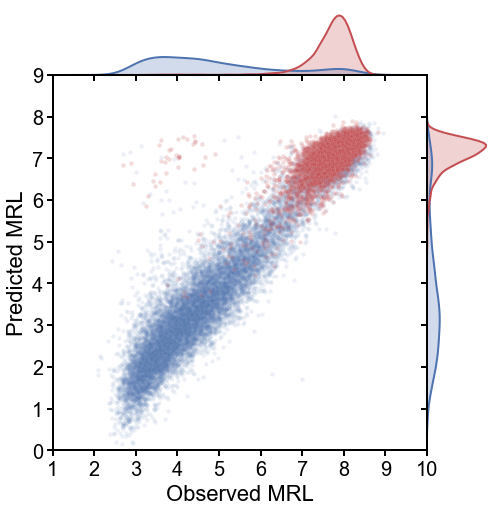

In [6]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

## Are the Off-Diagonal Sequences the Same?

(As compared to the authors' model, that is)

In [7]:
off_diagonal = e_test[(e_test['rl']<4.6)&(e_test['pred']>5.4)].sort_values(by='utr')
off_diagonal = off_diagonal.drop(columns=['Unnamed: 0'])
off_diagonal = off_diagonal.rename(columns={'pred':'pred_50bp'})
len(off_diagonal)

50

In [8]:
auth_off_diagonal = pd.read_csv('../off_diagonal_utrs.csv').sort_values(by='utr')
auth_off_diagonal = auth_off_diagonal.drop(columns=['Unnamed: 0.1','Unnamed: 0'])
auth_off_diagonal = auth_off_diagonal.rename(columns={'pred':'pred_auth'})
len(auth_off_diagonal)

48

In [9]:
rnn_off_diagonal = pd.read_csv('../off_diagonal_rnn_utrs.csv').sort_values(by='utr')
rnn_off_diagonal = rnn_off_diagonal.drop(columns=['Unnamed: 0'])
rnn_off_diagonal = rnn_off_diagonal.rename(columns={'pred':'pred_rnn'})
len(rnn_off_diagonal)

50

In [10]:
set_50bp = set(off_diagonal['utr'].values)
set_auth = set(auth_off_diagonal['utr'].values)
set_rnn = set(rnn_off_diagonal['utr'].values)

In [11]:
set_shared = set_50bp.intersection(set_auth).intersection(set_rnn)
len(set_shared)

45

In [12]:
z = off_diagonal[off_diagonal['utr'].isin(set_shared)].set_index('utr')
w = auth_off_diagonal[auth_off_diagonal['utr'].isin(set_shared)].set_index('utr')
u = rnn_off_diagonal[rnn_off_diagonal['utr'].isin(set_shared)].set_index('utr')
shared_off_diagonals = pd.concat([z,w['pred_auth'],u['pred_rnn']],axis=1)
shared_off_diagonals = shared_off_diagonals.reset_index()
shared_off_diagonals.head(3)

,utr,0,1,2,3,4,5,6,7,8,...,r8,r9,r10,r11,r12,r13,rl,pred_50bp,pred_auth,pred_rnn
0,AAACGCGGTGGATCACGGCCAGCTAGAGGGCGAAGGCGTCCTTCCACCAG,0.000031,0.000027,0.000013,0.000009,0.000007,0.000004,0.000003,0.000003,0.000004,...,0.030310,0.017522,0.033050,0.033050,0.026678,0.034121,3.237970,5.849938,5.670214,6.179446
1,ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC,0.000030,0.000032,0.000024,0.000016,0.000008,0.000007,0.000004,0.000004,0.000004,...,0.025049,0.024521,0.045485,0.045485,0.032901,0.031797,3.715876,6.207780,5.623970,6.539258
2,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,0.000034,0.000036,0.000025,0.000013,0.000009,0.000009,0.000005,0.000006,0.000005,...,0.030538,0.026672,0.043827,0.043827,0.042533,0.051309,4.065457,5.787129,5.995093,6.047128
3,ATCAGGGCTAGATTAATACGTAGCTCAGACAGTTATATTGAATCACCTGA,0.000017,0.000019,0.000017,0.000009,0.000005,0.000005,0.000003,0.000003,0.000005,...,0.046429,0.033113,0.043098,0.043098,0.048786,0.057706,4.411140,7.409012,7.143446,7.101318
4,CAATAGGCAGGTGCGCGCTACGCGCGGGATTCCTAGACCACTCGGTCAAT,0.000035,0.000026,0.000013,0.000007,0.000005,0.000004,0.000003,0.000003,0.000002,...,0.014933,0.025135,0.019118,0.019118,0.024517,0.026212,2.677383,6.840362,6.863350,6.812460
5,CACCGAGTCTTGCGGCCTAAATCCGTAGGGGTCTGGGTCCACGATTGTCC,0.000036,0.000031,0.000018,0.000009,0.000006,0.000007,0.000004,0.000004,0.000004,...,0.025882,0.026299,0.035648,0.035648,0.031976,0.037537,3.450179,6.618365,6.479451,6.480992
6,CACTCGTATACATATAACACGCAAATTGCTGTATCCATAAACAACGCAGT,0.000018,0.000019,0.000014,0.000007,0.000004,0.000004,0.000003,0.000004,0.000003,...,0.034665,0.044169,0.042853,0.042853,0.048468,0.039709,4.127045,7.523306,7.445688,7.339086
7,CAGCAGCGAGTGTCTGGCCGCGTTCAGGTAAAGGCGTAAACAACGCTCAG,0.000021,0.000022,0.000014,0.000007,0.000004,0.000005,0.000004,0.000004,0.000003,...,0.026501,0.031449,0.034996,0.034996,0.037160,0.046735,3.807885,6.988488,6.925332,6.839564
8,CAGTACCCGACGTGGGAAATTAACATACCATTGGACCCTTCCCACGTCAA,0.000027,0.000025,0.000015,0.000008,0.000006,0.000005,0.000004,0.000003,0.000003,...,0.029426,0.032772,0.041309,0.041309,0.038650,0.034648,3.701647,6.905163,6.924004,6.824212
9,CAGTCGGTAGATAAAGACCACACAGGCACCTGTCACCCGCTGCGTACCTC,0.000021,0.000023,0.000016,0.000007,0.000005,0.000005,0.000004,0.000004,0.000004,...,0.035963,0.038392,0.046187,0.046187,0.035746,0.039692,4.020205,6.783804,6.855105,6.806893


In [13]:
shared_off_diagonals.to_csv('../off_diagonal_utrs_shared.csv')

## Analyze 2ndary Structure of Shared Off-Diagonal Sequences

Prediction: they have more structure, statistically, than on-diagonal sequences

In [14]:
for seq in shared_off_diagonals['utr'].values[:5]:      
    # compute minimum free energy (MFE) and corresponding structure
    (ss, mfe) = RNA.fold(seq)
    # print output
    print "%s\n%s [ %6.3f ]\n" % (seq, ss, mfe)
    
get_mfe = lambda s: RNA.fold(s)[1]
shared_off_diagonals['mfe'] = [ get_mfe(s) for s  in shared_off_diagonals['utr'].values ]

AAACGCGGTGGATCACGGCCAGCTAGAGGGCGAAGGCGTCCTTCCACCAG
......((((((.....(((.(((....)))...))).....)))))).. [ -18.100 ]

ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC
...........................((.((((((.....)))))).)) [ -8.100 ]

AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG
...........((.......))(((((((((.(.....).))))))))). [ -13.600 ]

ATCAGGGCTAGATTAATACGTAGCTCAGACAGTTATATTGAATCACCTGA
.(((((......(((((..((((((.....)))))))))))....))))) [ -9.100 ]

CAATAGGCAGGTGCGCGCTACGCGCGGGATTCCTAGACCACTCGGTCAAT
...((((....(.(((((...))))).)...))))((((....))))... [ -17.300 ]



#### Note: The paper actually used an upstream constant segment as well. Include in varying amounts in MFE calculation!

In [26]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5') # load the author's model

In [27]:
# reset e_test
np.random.seed(1337)
e_test = df.iloc[:20000]
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [28]:
data = pd.DataFrame([e_test['utr'],e_test['rl'],e_test['pred']]).transpose()
data['pct_error'] = 100*np.abs(data['pred'] - data['rl'])/data['rl']

In [80]:
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"

def get_start_subseq(utr,n_bp=75):
    seq = upstream_constant+utr+eGFP+downstream_addition
    return seq[:min(n_bp,len(seq))]

data['mfe50'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,50)))
data['mfe75'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,75))) #just constant region + random region
data['mfe100'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,100)))
data['mfe150'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,150)))

In [81]:
data['is_offdiag'] = data['utr'].apply(lambda s: s in set_shared)
data.head()

,utr,rl,pred,pct_error,mfe75,mfe100,mfe150,is_offdiag,mfe50
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.03994,1.79714,40.8825,-16.0,-24.700001,-50.400002,False,-7.6
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,3.89511,2.89977,25.5535,-14.4,-25.600000,-50.900002,False,-9.0
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,3.33452,2.63852,20.8727,-12.6,-20.200001,-45.700001,False,-4.3
3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC,3.57508,2.58885,27.5864,-11.4,-19.100000,-47.000000,False,-5.5
4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC,4.59371,3.8103,17.0539,-17.5,-26.100000,-53.299999,False,-7.8


## Sample with Replacement for Statistical Analysis

### First 50 base pairs

mean: -7.895555612776015 std: 2.585941126852101


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 50 bp')

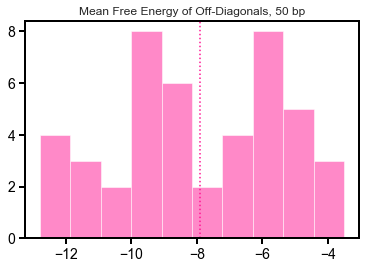

In [111]:
test50_values = data[data['is_offdiag'] == True]['mfe50'].values
test50_mean = np.mean(test50_values)
test50_std = np.std(test50_values)
print "mean:", test50_mean, "std:", test50_std
fig,ax = plt.subplots()
ax.hist(test50_values,color='deeppink',bins=10,alpha=0.5)
ax.axvline(test50_mean,color='deeppink',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 50 bp")

Sample mean: -7.895555612776015
Population mean: -8.597367563252977


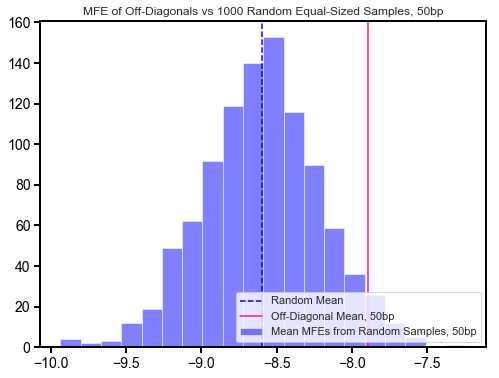

In [112]:
pop50_means = np.zeros(1000)
pop50_stds = np.zeros(1000)

np.random.seed(1336)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe50'].values
    pop50_means[i],pop150_stds[i] = np.mean(mfes),np.std(mfes)
    
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop50_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 50bp')
ax.axvline(np.mean(pop50_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test50_mean,color='deeppink',label='Off-Diagonal Mean, 50bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 50bp")
ax.legend(loc='lower right')
print "Sample mean:", test50_mean
print "Population mean:", np.mean(pop50_means)

In [84]:
count_more_extreme50 = np.count_nonzero(pop50_means < test50_mean)
print count_more_extreme50
n = (1-(count_more_extreme50/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


959
The mean MFE of the 45 off-diagonal sequences is lower than 4.1 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### First 75 base pairs (aka upstream constant region plus variable region)

In [86]:
test75_values = data[data['is_offdiag'] == True]['mfe75'].values
test75_mean = np.mean(test75_values)
test75_std = np.std(test75_values)
print "mean:", test75_mean, "std:", test75_std

mean: -16.344444508022733 std: 4.880690053766691


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 75 bp')

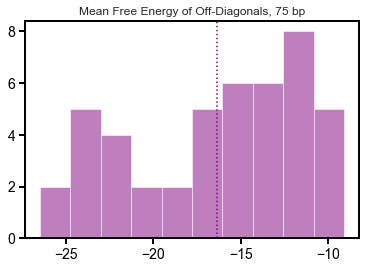

In [87]:
fig,ax = plt.subplots()
ax.hist(test75_values,color='purple',bins=10,alpha=0.5)
ax.axvline(test75_mean,color='purple',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 75 bp")

In [88]:
pop75_means = np.zeros(1000)
pop75_stds = np.zeros(1000)

np.random.seed(1337)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(e_test)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe75'].values
    pop75_means[i],pop75_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 500 == 0:
        print i+1
   

500
1000


Sample mean: -16.344444508022733
Population mean: -15.21443800412284


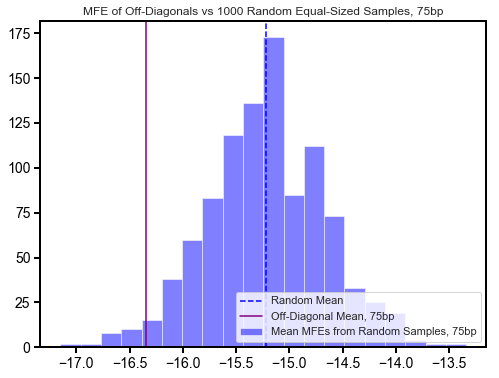

In [89]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop75_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 75bp')
ax.axvline(np.mean(pop75_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test75_mean,color='purple',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 75bp")
ax.legend(loc='lower right')
print "Sample mean:", test75_mean
print "Population mean:", np.mean(pop75_means)

In [91]:
count_more_extreme75 = np.count_nonzero(pop75_means < test75_mean)
print count_more_extreme75
n = (1-(count_more_extreme75/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


The mean MFE of the 45 off-diagonal sequences is lower than 97.6 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### First 100 base pairs

mean: -21.75555551317003 std: 4.567399155158655


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 100 bp')

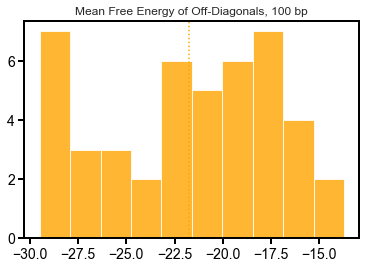

In [92]:
test100_values = data[data['is_offdiag'] == True]['mfe100'].values
test100_mean = np.mean(test100_values)
test100_std = np.std(test100_values)
print "mean:", test100_mean, "std:", test100_std
fig,ax = plt.subplots()
ax.hist(test100_values,color='orange',bins=10,alpha=0.8)
ax.axvline(test100_mean,color='orange',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 100 bp")

In [93]:
pop100_means = np.zeros(1000)
pop100_stds = np.zeros(1000)

np.random.seed(1338)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe100'].values
    pop100_means[i],pop100_stds[i] = np.mean(mfes),np.std(mfes)


Sample mean: -21.75555551317003
Population mean: -21.202959777969784


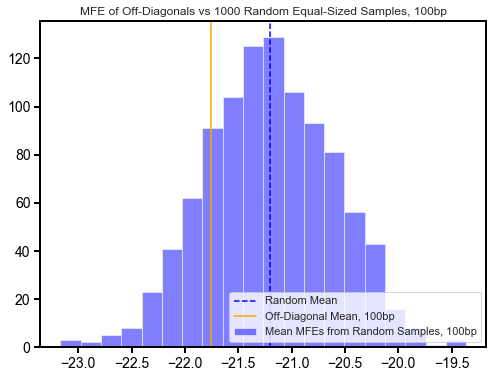

In [94]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop100_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 100bp')
ax.axvline(np.mean(pop100_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test100_mean,color='orange',label='Off-Diagonal Mean, 100bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 100bp")
ax.legend(loc='lower right')
print "Sample mean:", test100_mean
print "Population mean:", np.mean(pop100_means)

In [95]:
count_more_extreme100 = np.count_nonzero(pop100_means < test100_mean)
count_more_extreme100

185

In [104]:
n = (1-(count_more_extreme100/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


The mean MFE of the 45 off-diagonal sequences is lower than 81.5 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### First 150 Base pairs

mean: -47.21777784559462 std: 4.4814824052300315


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 150 bp')

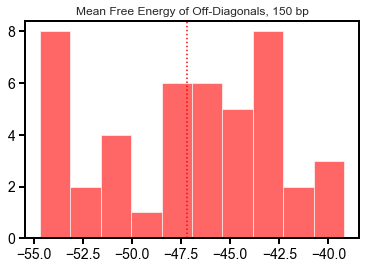

In [97]:
test150_values = data[data['is_offdiag'] == True]['mfe150'].values
test150_mean = np.mean(test150_values)
test150_std = np.std(test150_values)
print "mean:", test150_mean, "std:", test150_std
fig,ax = plt.subplots()
ax.hist(test150_values,color='red',bins=10,alpha=0.6)
ax.axvline(test150_mean,color='red',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 150 bp")

In [98]:
pop150_means = np.zeros(1000)
pop150_stds = np.zeros(1000)

np.random.seed(1339)
for i in range(1000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(shared_off_diagonals))
    mfes = data.iloc[indices]['mfe150'].values
    pop150_means[i],pop150_stds[i] = np.mean(mfes),np.std(mfes)


Sample mean: -47.21777784559462
Population mean: -47.08902311062283


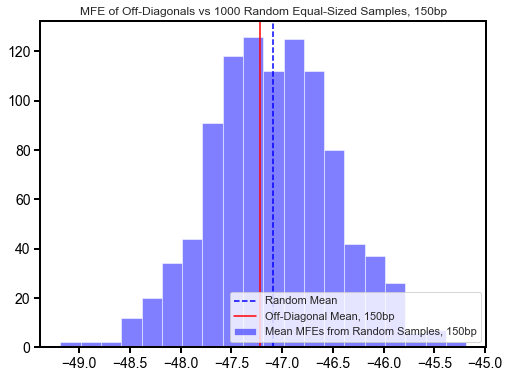

In [99]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop150_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 150bp')
ax.axvline(np.mean(pop150_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test150_mean,color='red',label='Off-Diagonal Mean, 150bp')
ax.set_title("MFE of Off-Diagonals vs 1000 Random Equal-Sized Samples, 150bp")
ax.legend(loc='lower right')
print "Sample mean:", test150_mean
print "Population mean:", np.mean(pop150_means)

In [100]:
count_more_extreme150 = np.count_nonzero(pop150_means < test150_mean)
count_more_extreme150

426

In [105]:
n = (1-(count_more_extreme150/1000.0))*100
print "The mean MFE of the 45 off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement from the same population of sequences"


The mean MFE of the 45 off-diagonal sequences is lower than 57.4 % of the means 
 obtained by sampling randomly with replacement from the same population of sequences


### Compare with the raw MFEs from everything, since we have the data

Text(0.5,1,'150bp')

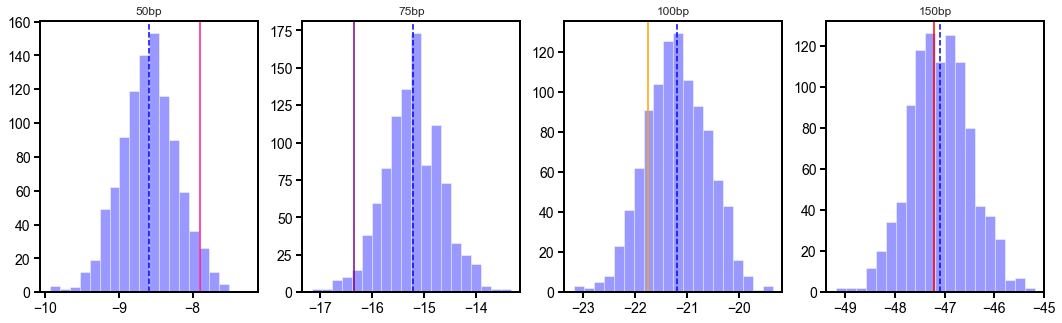

In [119]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(18,5))
ax1.hist(pop50_means,color='blue',alpha=0.4,bins=20)
ax1.axvline(np.mean(pop50_means),linestyle='--',color='blue')
ax1.axvline(test50_mean,color='deeppink')
ax1.set_title("50bp")
ax2.hist(pop75_means,color='blue',alpha=0.4,bins=20)
ax2.axvline(np.mean(pop75_means),linestyle='--',color='blue')
ax2.axvline(test75_mean,color='purple')
ax2.set_title("75bp")
ax3.hist(pop100_means,color='blue',alpha=0.4,bins=20)
ax3.axvline(np.mean(pop100_means),linestyle='--',color='blue')
ax3.axvline(test100_mean,color='orange')
ax3.set_title("100bp")
ax4.hist(pop150_means,color='blue',alpha=0.4,bins=20)
ax4.axvline(np.mean(pop150_means),linestyle='--',color='blue')
ax4.axvline(test150_mean,color='red')
ax4.set_title("150bp")

Text(0.5,1,'150bp')

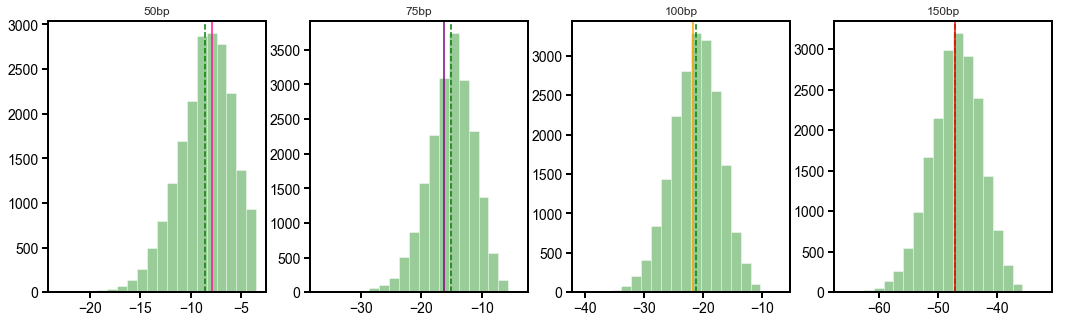

In [116]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(18,5))
ax1.hist(data['mfe50'].values,color='green',alpha=0.4,bins=20)
ax1.axvline(np.mean(data['mfe50'].values),linestyle='--',color='green')
ax1.axvline(test50_mean,color='deeppink')
ax1.set_title("50bp")
ax2.hist(data['mfe75'].values,color='green',alpha=0.4,bins=20)
ax2.axvline(np.mean(data['mfe75'].values),linestyle='--',color='green')
ax2.axvline(test75_mean,color='purple')
ax2.set_title("75bp")
ax3.hist(data['mfe100'].values,color='green',alpha=0.4,bins=20)
ax3.axvline(np.mean(data['mfe100'].values),linestyle='--',color='green')
ax3.axvline(test100_mean,color='orange')
ax3.set_title("100bp")
ax4.hist(data['mfe150'].values,color='green',alpha=0.4,bins=20)
ax4.axvline(np.mean(data['mfe150'].values),linestyle='--',color='green')
ax4.axvline(test150_mean,color='red')
ax4.set_title("150bp")

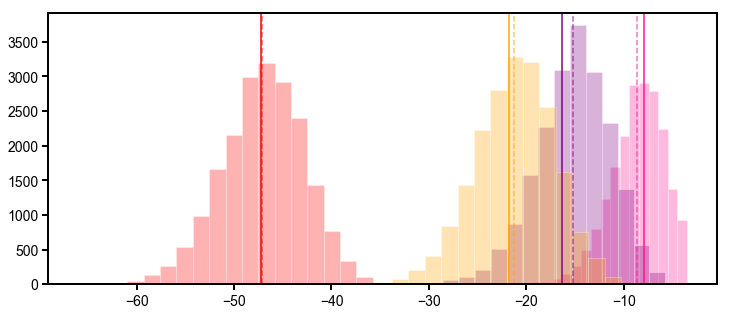

In [113]:
fig,ax = plt.subplots(figsize=(12,5))
ax.hist(data['mfe50'].values,color='deeppink',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe50'].values),linestyle='--',color='deeppink',alpha=0.6)
ax.axvline(test50_mean,color='deeppink')
ax.hist(data['mfe75'].values,color='purple',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe75'].values),linestyle='--',color='purple',alpha=0.6)
ax.axvline(test75_mean,color='purple')
ax.hist(data['mfe100'].values,color='orange',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe100'].values),linestyle='--',color='orange',alpha=0.6)
ax.axvline(test100_mean,color='orange')
ax.hist(data['mfe150'].values,color='red',alpha=0.3,bins=20)
ax.axvline(np.mean(data['mfe150'].values),linestyle='--',color='red',alpha=0.6)
ax.axvline(test150_mean,color='red')

### Other Statistical Tests to Try: Mann-Whitney-U

In [74]:
# also try Mann-Whitney and Wilcoxon (nonparamatric!) Effect size is fn of mann-whitney u statistic: 2u/mn 
# where m and n are the set sizes

## Try Same Tests on Off-Diagonals from Full Dataset

In [129]:
# "pred" is the predictions from the model 'main_CNN_model.hdf5'
data = pd.read_csv('../author_off_diagonal_from_full_dataset.csv')
data = data.drop(columns=['index','Unnamed: 0'])

In [130]:
data_full = pd.read_csv('../mfe_dataset.csv')
data_full = data_full.drop(columns=['Unnamed: 0'])

## 75 bp

In [131]:
test75_values = data['mfe75'].values
test75_mean = np.mean(test75_values)
test75_std = np.std(test75_values)
print "mean:", test75_mean, "std:", test75_std

mean: -15.487259142966312 std: 3.9958057715488002


Text(0.5,1,'Mean Free Energy of All Off-Diagonals, 75 bp')

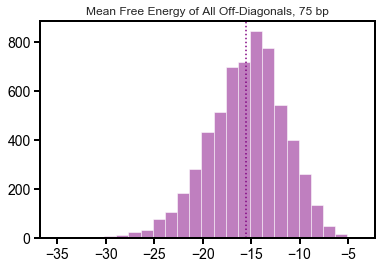

In [134]:
fig,ax = plt.subplots()
ax.hist(test75_values,color='purple',bins=25,alpha=0.5)
ax.axvline(test75_mean,color='purple',linestyle=":")
ax.set_title("Mean Free Energy of All Off-Diagonals, 75 bp")

In [138]:
pop75_means = np.zeros(8000)
pop75_stds = np.zeros(8000)

np.random.seed(1337)
for i in range(8000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data_full)),len(data))
    mfes = data_full.iloc[indices]['mfe75'].values
    pop75_means[i],pop75_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000


Sample mean: -15.487259142966312
Population mean: -15.041244267655559


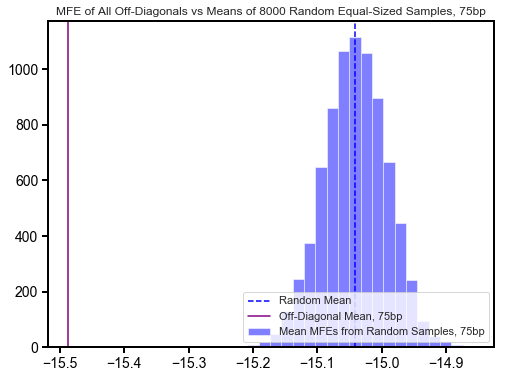

In [157]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop75_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 75bp')
ax.axvline(np.mean(pop75_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test75_mean,color='purple',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 75bp")
ax.legend(loc='lower right')
print "Sample mean:", test75_mean
print "Population mean:", np.mean(pop75_means)

In [166]:
count_more_extreme75 = np.count_nonzero(pop75_means < test75_mean)
print count_more_extreme75
n = (1-(count_more_extreme75/1000.0))*100
print "The mean MFE of the first 75 bp of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


0
The mean MFE of the first 75 bp of the 6155 total off-diagonal sequences is lower than 100.0 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


## 100 bp

mean: -20.89153696249211 std: 4.235328822609876


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 100 bp')

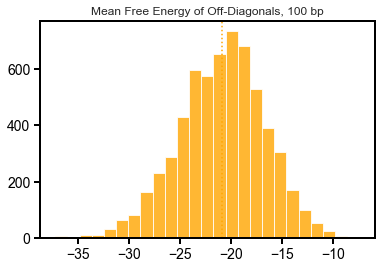

In [160]:
test100_values = data['mfe100'].values
test100_mean = np.mean(test100_values)
test100_std = np.std(test100_values)
print "mean:", test100_mean, "std:", test100_std
fig,ax = plt.subplots()
ax.hist(test100_values,color='orange',bins=25,alpha=0.8)
ax.axvline(test100_mean,color='orange',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 100 bp")

In [161]:
pop100_means = np.zeros(8000)
pop100_stds = np.zeros(8000)

np.random.seed(1337)
for i in range(8000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data_full)),len(data))
    mfes = data_full.iloc[indices]['mfe100'].values
    pop100_means[i],pop100_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000


Sample mean: -20.89153696249211
Population mean: -20.612682852225483


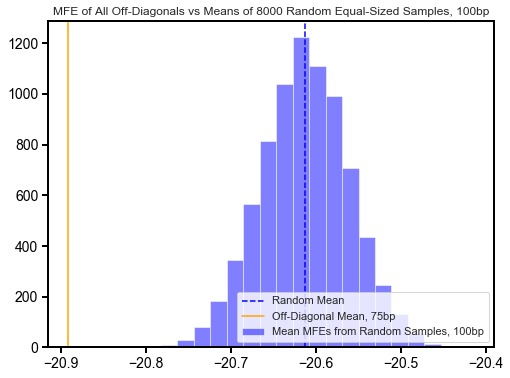

In [162]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop100_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 100bp')
ax.axvline(np.mean(pop100_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test100_mean,color='orange',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 100bp")
ax.legend(loc='lower right')
print "Sample mean:", test100_mean
print "Population mean:", np.mean(pop100_means)

In [165]:
count_more_extreme100 = np.count_nonzero(pop100_means < test100_mean)
print count_more_extreme100
n = (1-(count_more_extreme100/1000.0))*100
print "The mean MFE of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


0
The mean MFE of the 6155 total off-diagonal sequences is lower than 100.0 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


## 125 bp

mean: -33.03847275493011 std: 4.454780048753042


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 125 bp')

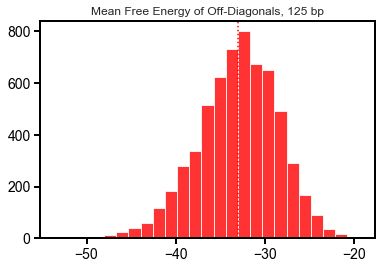

In [167]:
test125_values = data['mfe125'].values
test125_mean = np.mean(test125_values)
test125_std = np.std(test125_values)
print "mean:", test125_mean, "std:", test125_std
fig,ax = plt.subplots()
ax.hist(test125_values,color='red',bins=25,alpha=0.8)
ax.axvline(test125_mean,color='red',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 125 bp")

In [168]:
pop125_means = np.zeros(8000)
pop125_stds = np.zeros(8000)

np.random.seed(1337)
for i in range(8000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data_full)),len(data))
    mfes = data_full.iloc[indices]['mfe125'].values
    pop125_means[i],pop125_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000


Sample mean: -33.03847275493011
Population mean: -32.71934258432675


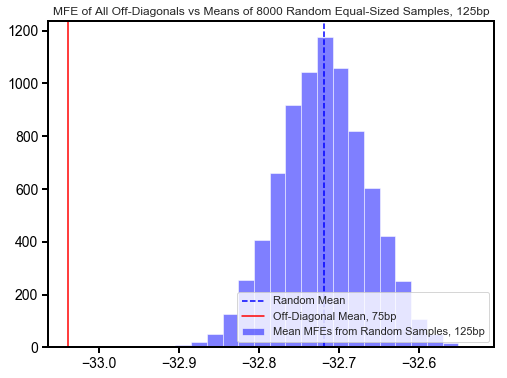

In [169]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop125_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 125bp')
ax.axvline(np.mean(pop125_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test125_mean,color='red',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 125bp")
ax.legend(loc='lower right')
print "Sample mean:", test125_mean
print "Population mean:", np.mean(pop125_means)

In [170]:
count_more_extreme125 = np.count_nonzero(pop125_means < test125_mean)
print count_more_extreme125
n = (1-(count_more_extreme125/1000.0))*100
print "The mean MFE of the firt 125bp of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


0
The mean MFE of the firt 125bp of the 6155 total off-diagonal sequences is lower than 100.0 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences
